<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/model_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model for Reviews


In [1]:
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 586, done.
remote: Counting objects: 100% (586/586), done.
remote: Compressing objects: 100% (553/553), done.
remote: Total 586 (delta 312), reused 152 (delta 27), pack-reused 0
Receiving objects: 100% (586/586), 3.98 MiB | 9.10 MiB/s, done.
Resolving deltas: 100% (312/312), done.


In [2]:
%cd airbnb_price
import sys
sys.path.append("/content/airbnb_price/custom_functions")
import general_utils as ut
device = ut.get_device()

/content/airbnb_price
cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB


In [3]:
%%capture
!pip install transformers
!pip install requests
!pip install captum

# Data Loading

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import fastprogress
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel
import torch.nn as nn
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Explore the dataset

In [5]:
path = "/content/drive/MyDrive/Colab/airbnb/data/reviews/df.pickle"
data = pd.read_pickle(path)
input_ids, attention_masks, labels = data['review_input_ids'], data['review_attention_masks'], data['log_price']

In [6]:
nreviews = np.vectorize(len)(input_ids)

In [7]:
input_ids = np.concatenate(np.array(input_ids))
attention_masks = np.concatenate(np.array(attention_masks))
labels = np.repeat(np.array(labels), nreviews)

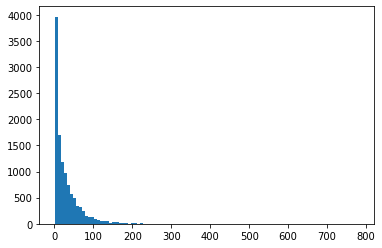

In [8]:
# TODO Visualize the length of the reviews in your dataset
def count_words(string):
    string = string[0]
    return len(string.split())

review_lengths = np.vectorize(count_words)(data["reviews"])

a = plt.hist(review_lengths, bins = 100)
plt.show()

In [9]:
%tensorflow_version 1.x
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

TensorFlow 1.x selected.


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Training, Validation, Test Split

Use 15% of the dataset as validation and test set, respectively. Use the other 70% for training.

In [10]:
train_ids, val_ids, test_ids = ut.train_val_test_split(data.index)  
traindf, valdf = data.loc[train_ids], data.loc[val_ids]
ids_train, labels_train, masks_train = traindf['review_input_ids'], traindf['log_price'], traindf['review_attention_masks']
ids_val, labels_val, masks_val = valdf['review_input_ids'], valdf['log_price'], valdf['review_attention_masks']
nreviews_train = np.vectorize(len)(ids_train)
nreviews_val = np.vectorize(len)(ids_val)

In [11]:
ids_train, ids_val =  np.concatenate(np.array(ids_train)), np.concatenate(np.array(ids_val))
labels_train, labels_val = np.repeat(np.array(labels_train), nreviews_train), np.repeat(np.array(labels_val), nreviews_val)
masks_train, masks_val = np.concatenate(np.array(masks_train)), np.concatenate(np.array(masks_val))

In [12]:
# TODO: Print out the shapes of your splitted train, validation, and test set
# Hint: your validation set should contain 500 samples. How many tokens are
# included per sample? 

# (1) print the feature shapes
print(ids_train.shape)
print(ids_val.shape)

# (2) print the label shapes
print(labels_train.shape)
print(labels_val.shape)

# (3) print the attention mask shapes
print(masks_train.shape)
print(masks_val.shape)

(256285, 128)
(54785, 128)
(256285,)
(54785,)
(256285, 128)
(54785, 128)


## Create DataLoader

You can use `TensorDataset`, `torch.from_numpy(...)`, and `DataLoader(...)` to create Dataloaders for your dataset holding features, labels and attention masks. Make sure to shuffle your training data. Is shuffling required for the validation and test data?

In [13]:
# TODO
# create dataloaders
from torch.utils.data import TensorDataset, DataLoader
trainset = TensorDataset(torch.from_numpy(ids_train), torch.from_numpy(labels_train), torch.from_numpy(masks_train))
valset = TensorDataset(torch.from_numpy(ids_val), torch.from_numpy(labels_val), torch.from_numpy(masks_val))

b = 256
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=False, num_workers=2, batch_size=b)


#regression model


In [ ]:
sys.path.append("/content/airbnb_price/models")
from language_model import LanguageBertNet

In [ ]:
!mkdir -p /content/checkpoints/

In [ ]:
import train_utils as train

In [ ]:
model1 = LanguageBertNet(fine_tune=False, with_attention_masks=True)
model1 = model1.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10)
result = train.run_training(model1, optimizer, loss_fn, device, 30, trainloader, valloader, verbose=True, 
                            scheduler=scheduler, ntrain=300, nval=100)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Saving model...
Saving model...
Saving model...
Finished training after 11934 seconds.


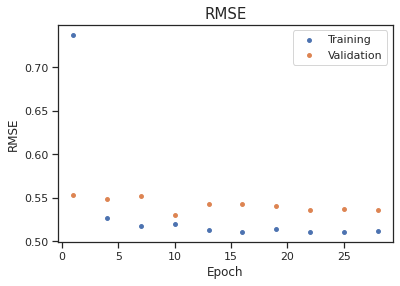

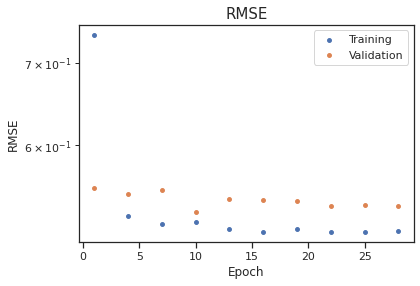

In [ ]:
# plot train and test
train_losses, val_losses, train_rmse, val_rmse = result
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='linear')
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='log')

In [ ]:

path ="/content/checkpoints/train_loss.npy"
np.save(path, train_losses)
path ="/content/checkpoints/val_loss.npy"
np.save(path, val_losses)

# do you want to save a checkpoint run this chunk
!mkdir -p /content/drive/MyDrive/Colab/airbnb/logs/reviews/TEST
!cp -r /content/checkpoints/ /content/drive/MyDrive/Colab/airbnb/logs/reviews/TEST

In [ ]:
model1.load_state_dict(torch.load("/content/checkpoints/checkpoint.pt"))

<All keys matched successfully>

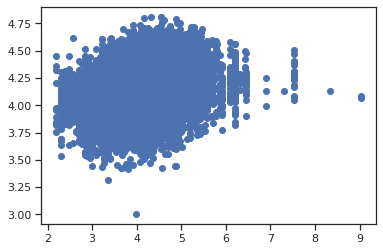

(0.29098368699670313, 0.0)

In [ ]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt

ys = []
ypreds = []

with torch.no_grad():
    model = model1.eval()

    for ids, labels, masks in valloader:
        ids, masks = ids.to(device), masks.to(device)
        y_pred = model1(ids, masks)[0]
        y_pred = list(y_pred.detach().cpu())
        ypreds = ypreds + y_pred

        ys = ys + list(labels)


plt.scatter(ys, ypreds)
plt.show()
pearsonr(ys, ypreds)

## Inference testing

In [ ]:
import explainability_utils as explain
text = "This is a luxurious spa appartment, with the best location in the centre of downtown vienna"
attention = explain.pipeline(text, model1, device)
explain.visualize_attention(text, attention)

83.31549835205078


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


## [Optional] Fine-tune BERT model

(This is a non-mandatory, fully optional task)

Can you improve performance by fine-tuning BERT in addition to training the readout classifier?

In [ ]:
b = 64
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=False, num_workers=2, batch_size=b)
model2 = LanguageBertNet(fine_tune=True, with_attention_masks=True, cls_dropout_prob=0.5)
model2 = model2.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10)
result = train.run_training(model2, optimizer, loss_fn, device, 30, trainloader, valloader, verbose=True, 
                            scheduler=scheduler, ntrain=300, nval=100)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Saving model...
Saving model...
Saving model...
Saving model...
Saving model...


KeyboardInterrupt: ignored

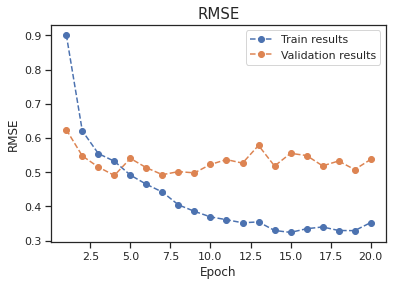

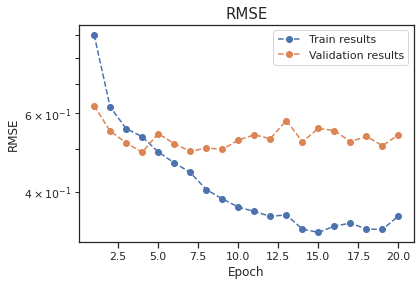

In [ ]:
# plot train and test
train_losses, val_losses, train_rmse, val_rmse = result
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='linear')
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='log')

In [ ]:

path ="/content/checkpoints/train_loss.npy"
np.save(path, train_losses)
path ="/content/checkpoints/val_loss.npy"
np.save(path, val_losses)

# do you want to save a checkpoint run this chunk
!mkdir -p /content/drive/MyDrive/Colab/airbnb/logs/reviews/TEST
!cp -r /content/checkpoints/ /content/drive/MyDrive/Colab/airbnb/logs/reviews/TEST

In [ ]:
model2.load_state_dict(torch.load("/content/checkpoints/checkpoint.pt"))

<All keys matched successfully>

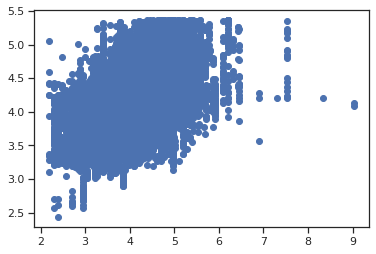

(0.4967879201383987, 0.0)

In [ ]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm

ys = []
ypreds = []

with torch.no_grad():
    model = model2.eval()

    for ids, labels, masks in tqdm(valloader):
        ids, masks = ids.to(device), masks.to(device)
        y_pred = model(ids, masks)[0]
        y_pred = list(y_pred.detach().cpu())
        ypreds = ypreds + y_pred

        ys = ys + list(labels)


plt.scatter(ys, ypreds)
plt.show()
pearsonr(ys, ypreds)

In [ ]:
text = "This is a modest appartment, with a backyard location in the centre of downtown vienna"
attention = explain.pipeline(text, model1, device)
explain.visualize_attention(text, attention)

86.10343170166016


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


In [ ]:
path ="/content/checkpoints/train_loss.npy"
np.save(path, train_losses)
path ="/content/checkpoints/val_loss.npy"
np.save(path, val_losses)

# do you want to save a checkpoint run this chunk
!mkdir -p /content/drive/MyDrive/Colab/airbnb/logs/reviews/fine_tuned_0525
!cp -r /content/checkpoints/ /content/drive/MyDrive/Colab/airbnb/logs/reviews/fine_tuned_0525

# Generate embeddings

In [14]:
# load model
sys.path.append("/content/airbnb_price/models")
from language_model import LanguageBertNet
model = LanguageBertNet(fine_tune=False, with_attention_masks=True)
path = "/content/drive/MyDrive/Colab/airbnb/logs/reviews/fine_tuned_0525/checkpoints/checkpoint.pt"
model.load_state_dict(torch.load(path))
model = model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
input_ids, attention_masks, index = data['review_input_ids'], data['review_attention_masks'], data.index

In [31]:
# generate embeddings
embeddings = torch.empty((len(data), 100))
model.eval()
indices = []
with torch.no_grad():
    for i, (ids, masks, idx) in enumerate(zip(input_ids, attention_masks, index)):
        ls = []
        for single_ids, single_masks in zip(ids, masks):
            single_ids, single_masks = torch.tensor(single_ids).to(device), torch.tensor(single_masks).to(device)
            single_ids, single_masks = torch.unsqueeze(single_ids, 0), torch.unsqueeze(single_masks, 0)
            embedding = model.genembeddings(single_ids, single_masks)
            embedding = list(embedding.detach().cpu().numpy())
            ls = ls + embedding
        embeddings[i] = torch.tensor(np.mean(ls))
        indices = indices + list(idx)

TypeError: ignored

In [29]:
%debug

> /usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py(136)asanyarray()
    134 
    135     """
--> 136     return array(a, dtype, copy=False, order=order, subok=True)
    137 
    138 

ipdb> up
> /usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py(144)_mean()
    142 
    143 def _mean(a, axis=None, dtype=None, out=None, keepdims=False):
--> 144     arr = asanyarray(a)
    145 
    146     is_float16_result = False

ipdb> up
> /usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py(3373)mean()
   3371 
   3372     return _methods._mean(a, axis=axis, dtype=dtype,
-> 3373                           out=out, **kwargs)
   3374 
   3375 

ipdb> up
> <__array_function__ internals>(6)mean()

ipdb> up
> <ipython-input-28-f1f18f865520>(15)<module>()
     11             embedding = model.genembeddings(single_ids, single_masks)
     12             embedding = list(embedding.detach().cpu())
     13             ls = ls + embedding
     14         embeddings[i] = np.mea

In [ ]:
# save embeddings in pandas dataframe
df = pd.Series(embeddings.numpy().tolist(), name="reviews", index=indices)
path = "/content/drive/MyDrive/Colab/airbnb/data/embeddings/reviews.pickle"
df.to_pickle(path)